In [1]:
from sentence_transformers import SentenceTransformer
import torch
import lancedb
from lancedb.rerankers import LinearCombinationReranker, RRFReranker
from openai import OpenAI
import re
from pathlib import Path
import json

from google import genai
from google.genai import types
from dotenv import load_dotenv

load_dotenv('env_var')

from burr.core import action, State, ApplicationBuilder, ApplicationContext, Action
from burr.core.parallelism import MapStates, RunnableGraph

In [113]:
# %load_ext burr.integrations.notebook
# %burr_ui

The burr.integrations.notebook extension is already loaded. To reload it, use:
  %reload_ext burr.integrations.notebook


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Research Report Burr

In [3]:
extraction_prompt = """
Documents:
{documents}


Task: Identify the relevant sections to the topic, question, and focus. The topic that the question relates to is {topic} and the focus of interest is {focus}. The only thing you are to provide are a list of the citations. The different documents begin with the report number and the title of the report. This report number is the report_id in the citation pattern.

The title is only to provide context for what the report is about. You must not reference it.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the answer.
Focus solely on fulfilling the request.

Question: {question}

Instructions:
- Identify only the sections that provide useful information for answering the provided question.
- The citation pattern follows the pattern '([report_id]([section_number]))' as provided in the citation field of the documents. Do not use the brackets in your response, those are only there to indicate what values are in the citation.
- If no relevant sections are found for a question, indicate "No relevant sections found."
- Once the relevant sections are found, provide the citation pattern in a comma separated list.
- Do not introduce your answer, ask follow up questions, or provide a summary or outro. Only provide the list.
- Citations for relevant information must be provided with both the report_id and section_number where the information is from.
- A citation for a section can refer to multiple passages above it. Do not create new citations just because a paragraph or passage does not have a citation immediately after the passage. It'll be found at the end of the section.

Relevant Sections:
"""

query_expansion_prompt = """Task: I have a question about {topic}. I am focusing my research on finding information related the question: {question}. The general direction of this research is based on my focus that I have set forth for broader research: {focus}.

Instructions:
- Write at most two paragraphs that provides an answer to my question in the context of my topic and focus.
- Provide both general terminology and any specific, domain relevant, terms in your answer. This will help me understand the topic and focus on both a high level communicable level and details that provide crucial examples.
- Your answer should not be long. This is meant to get me started, not be a final answer on the subject.

Response Instructions:
- Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
- Do not include any concluding remarks or follow-up questions.
- Respond only with the requested information.
- Avoid any conversational filler.
- Do not engage in dialogue. Only provide the answer.
- Focus solely on fulfilling the request.

Answer: """

search_expansion_prompt = """
Task: Generate 3 focused search questions for me to begin my research with.

Topic: {topic}
Focus: {focus}

Instructions:
- Create 3 questions that address the issues that should begin strongly relevant research with.
- Questions should directly address the intersection of the Topic and Focus.
- Prioritize questions that can be answered with factual information by Congressional Research Services reports.

- Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
- Do not include any concluding remarks or follow-up questions.
- Respond only with the requested information.
- Avoid any conversational filler.
- Do not engage in dialogue. Only provide the answer.
- Focus solely on fulfilling the request.

Questions:
1.
2.
3.
"""

report_prompt = """
Sources:
{sources}

Using the topic, {topic}, and the focus of research write a research report, while only using the sources of information, extract the relevant information from the sources and organize it into a well structured report that provides all the relevant details, context for the details, all the scenarios and situations discussed in the sources (if there are any). If there are case studies provided, extract that information too.

Instructions:
- You must not add any information, details, or hypotheticals to the report unless they are explicitly discussed in my sources.
- Carefully analyze what the major themes, topics, and situations of the sources are and which are relevant to the focus of my research on my topic.
- It is critical that you do not invent sources.
- It is critical that you provide the citation for each statement, fact, and scenario that you write about in your report.
- Work hierarchically for structuring your report. The main structure of your report should be organized into main sections by theme, followed by subsections containing the important facts, scenarios, any discussion from the sources about that topic, and a final summarization.
- Be thorough and avoid simplification. These are complex topics.
- Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
- Do not include any concluding remarks or follow-up questions.
- Respond only with the requested information.
- Avoid any conversational filler.
- Do not engage in dialogue. Only provide the answer.
- Focus solely on fulfilling the request.
- Provide the report between the tags: <report>...</report>

Report:
"""

In [4]:
def format_documents(documents):
    formatted_texts = []
    report_ids = list(set([record['id'] for record in documents]))
    for id in report_ids:
        report_sections = [section for section in documents if section['id'] == id]
        report_sections = sorted(report_sections, key=lambda section: section['section_start'])
        report_text = [text['text'] for text in report_sections]
        report_text = [re.sub('\n+', '\n', _text) for _text in report_text]
        report_text = [re.sub(' +', ' ', _text) for _text in report_text]
        report_text = [re.sub(r'(\[.*?\])','', _text) for _text in report_text]
        report_text = [_text.replace('\\','') for _text in report_text]
        report_text = [re.sub(r'(\[.*?\])','', _text) for _text in report_text]
        report_text = [re.sub(r'(\n?-{10,})','', _text) for _text in report_text]
        report_text = [re.sub(r'(\n.*?#_Toc.*?\n)','', _text) for _text in report_text]
        report_text = [re.sub(r'(- \n)','', _text) for _text in report_text]
        report_text = [re.sub(r'\n{2,}','\n', _text) for _text in report_text]
        report_text = [_text.strip() for _text in report_text]
        report_text = '\n-----\n'.join(report_text)
        report_header = f"""**{report_sections[0]['id']}:** {report_sections[0]['title']}"""
        formatted_texts.append(f"""{report_header}\n{report_text}""".strip())
    # print(formatted_texts[0])
    return '\n=======\n'.join(formatted_texts)

client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
def call_llm(query, temperature=0.35, seed=42, model="gemma-3-4b-it-qat"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": query}
        ],
        temperature=temperature,
        seed=seed,
    )
    return completion.choices[0].message.content

model = "gemini-2.0-flash"
total_tokens = list()

def call_llm_flash(query, temperature=0.1, seed=42, max_tokens=7500 ):
    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])
    response = client.models.generate_content(
        model=model,
        contents=[query],
        config=types.GenerateContentConfig(
            max_output_tokens=max_tokens,
            temperature=temperature,
            seed=seed
        )
    )
    total_tokens.append({'prompt_tokens':response.usage_metadata.prompt_token_count,
                         'completion_tokens':response.usage_metadata.candidates_token_count,
                         'total_tokens':response.usage_metadata.total_token_count,
                         'timestamp':datetime.now().strftime("%Y_%m_%d_%H_%M_%S")})

    return response.text

In [5]:
@action(reads=[], writes=['search_expansion_prompt'])
def search_expansion_prompt_format(state: State, topic: str, focus: str, prompts: dict) -> State:
    formatted_prompt = prompts['search_expansion_prompt'].format(topic=topic,
                                                                 focus=focus)
    return state.update(search_expansion_prompt=formatted_prompt)

@action(reads=['search_expansion_prompt'], writes=['search_expansion'])
def search_expansion(state: State) -> State:
    expansion_prompt = state['search_expansion_prompt']
    # search_expansion = call_llm(expansion_prompt, model="gemma-3-12b-it-qat")
    search_expansion = call_llm_flash(expansion_prompt)
    search_expansion = re.findall(r'\d+\. (.+?\?)', search_expansion)
    return state.update(search_expansion=search_expansion)

In [6]:
@action(reads=['search_expansion'], writes=['query_expansion'])
def query_expansion(state: State, topic: str, focus: str, prompts: dict) -> State:
    queries = list()
    for question in state['search_expansion']:
        expansion_prompt = prompts['query_expansion_prompt'].format(topic=topic,
                                                         focus=focus,
                                                         question=question)
        # query_expansion = call_llm(expansion_prompt, model="gemma-3-12b-it-qat")
        query_expansion = call_llm_flash(expansion_prompt)
        queries.append({'question': question, 'query': query_expansion})
    return state.update(query_expansion=queries)

In [7]:
@action(reads=['query_expansion'], writes=["query_expansion"])
def embed_text(state: State) -> State:
    query_expansions = list()
    for expansion in state['query_expansion']:
        embedding = encoder.encode(expansion['query'],
                                   padding=False,
                                   show_progress_bar=False).tolist()
        expansion['vector'] = embedding
        query_expansions.append(expansion)
        torch.mps.empty_cache()
    return state.update(query_expansion=query_expansions)

@action(reads=["query_expansion"], writes=["documents"])
def retrieve_documents(state: State, number_of_results: int, index_locations: dict) -> State:
    index = lancedb.connect(index_locations['index_path'])
    table = index.open_table(index_locations['index_table'])
    expansions = state['query_expansion']
    search_results = list()
    for expansion in expansions:
        query_embedding = expansion["vector"]
        sanitized_query = ' '.join(re.findall(r'(\w+)', expansion['query']))
        results = table.search(query_type='hybrid') \
            .vector(query_embedding) \
            .text(sanitized_query) \
            .limit(number_of_results) \
            .select(['id','title','text','summary','section_start','section_end']) \
            .to_pandas()

        if 'score' in results.columns:
            results['report_score'] = results.groupby('id')['score'].transform('max')
        elif '_distance' in results.columns:
            results['score'] = 1 - results['_distance']
            results['report_score'] = results.groupby('id')['score'].transform('max')
        elif '_relevance_score' in results.columns:
            results['report_score'] = results['_relevance_score']
        results = results.sort_values(['report_score','section_start'], ascending=[False,True])
        search_results.append(results.to_dict(orient='records'))

    return state.update(documents=search_results)

In [8]:
@action(reads=["query_expansion", "documents"], writes=["extraction_prompt"])
def build_extraction_prompt(state: State, topic: str, focus: str, prompts: dict) -> State:
    extraction_prompts = list()
    for _expansion, _documents in zip(state['query_expansion'], state['documents']):
        formatted_documents = format_documents(_documents)
        # print(_expansion)
        prompt = prompts['relevant_documents_prompt'].format(question=_expansion['question'],
                                          topic=topic,
                                          focus=focus,
                                          documents=formatted_documents)
        extraction_prompts.append(prompt)
    return state.update(extraction_prompt=extraction_prompts)


@action(reads=["extraction_prompt"], writes=["extraction"])
def generate_extraction(state: State) -> State:
    extractions = list()
    for _expansion_prompt in state['extraction_prompt']:
        # extraction = call_llm(_expansion_prompt)
        extraction = call_llm_flash(_expansion_prompt)
        extractions.append(extraction)
    return state.update(extraction=extractions)

In [9]:
@action(reads=["extraction","documents"], writes=["report_grounding", "relevant_citations"])
def merge_grounding(state: State) -> State:
    retrieved_documents = list()
    for result_set in state['documents']:
        retrieved_documents.extend(result_set)
    retrieved_documents = pd.DataFrame(retrieved_documents)
    retrieved_documents = retrieved_documents.drop_duplicates(subset=['id','section_start'], keep='first')
    retrieved_documents = retrieved_documents.sort_values(by=['id','section_start'], ascending=[False,True])
    retrieved_documents = retrieved_documents.to_dict(orient='records')

    relevant_citations = ""
    for extraction in state['extraction']:
        relevant_citations += f", {extraction}"
    relevant_citations = sorted(list(set(re.findall(r'(\w+\(\d+\))', relevant_citations))))

    relevant_sections = list()
    for row in retrieved_documents:
        for citation in relevant_citations:
            if citation in row['text']:
                relevant_sections.append(row)
                break

    relevant_sections = pd.DataFrame(relevant_sections)
    relevant_sections = relevant_sections.drop_duplicates(subset=['id','section_start'], keep='first')
    relevant_sections = relevant_sections.sort_values(by=['id','section_start'], ascending=[False,True])
    relevant_sections = relevant_sections.to_dict(orient='records')

    return state.update(report_grounding=relevant_sections, relevant_citations=relevant_citations)

In [10]:
@action(reads=["report_grounding"], writes=["formatted_report_grounding", "report_prompt"])
def format_report_prompt(state: State, topic: str, focus: str, prompts: dict) -> State:
    grounding = state['report_grounding']
    formatted_grounding = format_documents(grounding)
    formatted_prompt = prompts['report_prompt'].format(topic=topic,focus=focus, sources=formatted_grounding)
    return state.update(formatted_report_grounding=formatted_grounding, report_prompt=formatted_prompt)

@action(reads=["report_prompt"], writes=["report"])
def generate_report(state: State) -> State:
    # report = call_llm(state['report_prompt'], model="gemma-3-4b-it-qat")
    report = call_llm_flash(state['report_prompt'])
    report = report.replace('$','\\$')
    extracted_report = re.search(r'<report>(.*?)</report>', report, flags=re.DOTALL)
    if extracted_report:
        report = extracted_report.group(1)
    return state.update(report=report)

In [11]:
report_generation_app = (
    ApplicationBuilder()
    .with_actions(
        search_expansion_prompt_format,
        search_expansion,
        query_expansion,
        embed_text,
        retrieve_documents,
        build_extraction_prompt,
        generate_extraction,
        merge_grounding,
        format_report_prompt,
        generate_report
    )
    .with_transitions(
        ("search_expansion_prompt_format", "search_expansion"),
        ("search_expansion", "query_expansion"),
        ("query_expansion", "embed_text"),
        ("embed_text", "retrieve_documents"),
        ("retrieve_documents", "build_extraction_prompt"),
        ("build_extraction_prompt","generate_extraction"),
        ("generate_extraction","merge_grounding"),
        ("merge_grounding", "format_report_prompt"),
        ("format_report_prompt", "generate_report"))
    .with_entrypoint("search_expansion_prompt_format")
    .with_tracker(
        "local",
        project=f"research_batch-single_run",
    )
    .build()
)

In [12]:
index = lancedb.connect('../wonky_data/indexes/')
table = index.open_table('sections_hybrid')
encoder = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', device='mps',trust_remote_code=True)

pipeline_prompts = {"relevant_documents_prompt":extraction_prompt,
                  "query_expansion_prompt":query_expansion_prompt,
                  "search_expansion_prompt":search_expansion_prompt,
                  "report_prompt":report_prompt}

index_locations = {'index_path':'../wonky_data/indexes/',
                   'index_table':'sections_hybrid'}

topic = "Rural Broadband in America"
focus = "Historical, current, and future challenges for rural broadband and connectivity in America"


!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>


In [13]:
report_action, report_result, report_state = report_generation_app.run(
    halt_after=["generate_report"],
    inputs={
        "topic": topic,
        "focus": focus,
        "number_of_results": 10,
        "prompts": pipeline_prompts,
        "index_locations": index_locations
    }
)

In [14]:
report_data = report_state.get_all()

In [15]:
report_data['topic'] = topic
report_data['focus'] = focus

In [16]:
report_data.keys()

dict_keys(['__SEQUENCE_ID', 'search_expansion_prompt', '__PRIOR_STEP', 'search_expansion', 'query_expansion', 'documents', 'extraction_prompt', 'extraction', 'report_grounding', 'relevant_citations', 'formatted_report_grounding', 'report_prompt', 'report', 'topic', 'focus'])

In [17]:
save_path = Path('wonky_data')
trace_data = save_path.joinpath('data/research_data')
document_data = save_path.joinpath('documents')

from datetime import datetime
short_name = re.findall(r'(\w+)', topic)
short_name = ' '.join([x.lower() for x in short_name[:5]])
short_name = f"{short_name}_{datetime.now().strftime('%Y%m%d%H%M%S')}"

In [18]:
with open(trace_data.joinpath(short_name + '.json'), 'w') as f:
    json.dump(report_data, f)

In [19]:
with open(document_data.joinpath(short_name + '.md'), 'w') as f:
    f.write(report_data['report'])

# Wikipedia Burr

In [20]:
from sentence_transformers import SentenceTransformer
import lancedb
from tqdm.notebook import tqdm
import torch
import re
import pandas as pd
import json
from datetime import datetime
from dotenv import load_dotenv

from openai import OpenAI
from google import genai
from google.genai import types
from sklearn.metrics.pairwise import cosine_similarity
import os
import time
load_dotenv('env_var')

import wikipediaapi
import wikipedia
from burr.core import action, State, ApplicationBuilder, ApplicationContext, Action
from burr.core.parallelism import MapStates, RunnableGraph

from working_folder.workflows.topic_trend_research.processes.report_prompts import trend_report_prompt, follow_up_prompt, follow_up_query_prompt, \
                                                                                executive_summary_prompt

wiki_wiki = wikipediaapi.Wikipedia(user_agent='Wonky', language='en')

In [21]:
wikipedia_query_prompt = """I have an article that I'm reading and I want to follow up on it with reading through some wikipedia articles. I'm not sure what to search on wikipedia, so please provide me 2 or 3 short queries that I can put into their search. Provide them as just a list of the queries that I can run.

The queries should cover specific sections of the article AND have topical phrases that are about the entire document that must be in every query. The topical phrases can be inferred from the title of the document.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the answer.
Focus solely on fulfilling the request.

Do not introduce your response or provide any follow up questions or conclusion. The list should be a numbered list:

Here is the article I'm reading:

{report}"""

In [22]:
from copy import deepcopy
class ParseWikipediaSections():
    def __init__(self):
        self.parsed_sections = list()
        self.current_hierarchy = {'level_0':'', 'level_1':'', 'level_2':'', 'level_3':'', 'level_4':''}

    def _recursive_extract(self, sections, level=0):
        for s in sections:
            # print("%s: %s - %s" % ("*" * (level + 1), s.title, s.text[0:40]))
            hierarchy_string = list()
            for i in range(0,5):
                if i == level:
                    self.current_hierarchy[f"level_{i}"] = s.title
                elif i > level:
                    self.current_hierarchy[f"level_{i}"] = ''

            for i in range(0,5):
                _hierarchy_header = self.current_hierarchy[f"level_{i}"]
                if _hierarchy_header != "":
                    hierarchy_string.append(_hierarchy_header)
            hierarchy_string = '|'.join(hierarchy_string)

            self.parsed_sections.append({"level": level,
                                         "title": s.title,
                                         "text": s.text,
                                         "hierarchy": deepcopy(self.current_hierarchy),
                                         "hierarchy_string": hierarchy_string})

            self._recursive_extract(s.sections, level + 1)

    def parse_wikipedia_sections(self, sections):
        self._recursive_extract(sections, level=0)
        return self.parsed_sections

def get_wikipedia_data(page_name):
    wiki_wiki = wikipediaapi.Wikipedia(user_agent='Wonky', language='en')
    wikipedia_page = wiki_wiki.page(page_name)
    wikipedia_parser = ParseWikipediaSections()
    parsed_sections = wikipedia_parser.parse_wikipedia_sections(wikipedia_page.sections)
    wikipedia_data = {'title': wikipedia_page.title,
                      'url': wikipedia_page.fullurl,
                      'sections': parsed_sections}
    return wikipedia_data

def search_wikipedia_page(query, num_results=10):
    wiki_wiki = wikipediaapi.Wikipedia(user_agent='Wonky', language='en')
    search_results = wikipedia.search(query, results=num_results, suggestion=False)
    print(search_results)
    wikipedia_page_results = list()
    for search_result in search_results:
        wikipedia_page = wiki_wiki.page(search_result)
        wikipedia_parser = ParseWikipediaSections()
        parsed_sections = wikipedia_parser.parse_wikipedia_sections(wikipedia_page.sections)
        try:
            wikipedia_data = {'title': wikipedia_page.title,
                              'url': wikipedia_page.fullurl,
                              'sections': parsed_sections,
                              'full_text': wikipedia_page.text}
        except Exception as e:
            continue
        wikipedia_page_results.append(wikipedia_data)
        time.sleep(1)
    return wikipedia_page_results

In [23]:
@action(reads=[], writes=["formatted_search_expansion_prompt"])
def format_search_expansion_prompt(state: State, prompts: dict, report: str) -> State:
    formatted_prompt = prompts['search_expansion_prompt'].format(report=report)
    return state.update(formatted_search_expansion_prompt=formatted_prompt)

@action(reads=["formatted_search_expansion_prompt"], writes=["search_expansions"])
def generate_searches(state: State) -> State:
    # search_expansions = call_llm(state['formatted_search_expansion_prompt'])
    search_expansions = call_llm_flash(state['formatted_search_expansion_prompt'])
    search_expansions = re.findall(r'\d+\.(.+)', search_expansions)
    search_expansions = [x.strip() for x in search_expansions]
    return state.update(search_expansions=search_expansions)

In [24]:
@action(reads=["search_expansions"], writes=["wiki_research"])
def search_wikipedia(state: State, topic: str, focus: str, report: str, report_name: str, num_results: int) -> State:
    wiki_research = list()
    for search in state['search_expansions']:
        wiki_articles = search_wikipedia_page(search, num_results=num_results)
        wiki_research.append({'topic': topic,
                              'focus': focus,
                              'report': report,
                              'context': wiki_articles,
                              'source_report': report_name,
                              'search': search
                              })
    return state.update(wiki_research=wiki_research)

In [25]:
@action(reads=["wiki_research"], writes=["vectorized_wiki_research"])
def vectorize_wikipedia_data(state: State, topic: str, focus: str) -> State:
    vectorized_sections = list()
    for search_results in tqdm(state['wiki_research']):
        context_topic = topic
        context_focus = focus
        context_query = search_results['search']
        for wiki_page in tqdm(search_results['context']):
            wiki_page_title = wiki_page['title']
            for section_idx, section in tqdm(enumerate(wiki_page['sections'])):
                section_copy = deepcopy(section)
                section_copy['vector'] = encoder.encode(f"{wiki_page_title}\n{section_copy['title']}\n{' '.join(section_copy['hierarchy_string'].split('|'))}\n{section_copy['text']}").tolist()

                section_copy['topic'] = context_topic
                section_copy['focus'] = context_focus
                section_copy['query'] = context_query
                section_copy['page_title'] = wiki_page_title
                section_copy['section_idx'] = section_idx

                vectorized_sections.append(section_copy)
                torch.mps.empty_cache()
    return state.update(vectorized_wiki_research=vectorized_sections)

In [26]:
@action(reads=["vectorized_wiki_research"], writes=[])
def index_wikipedia_articles(state: State, index_location: str, index_table: str) -> State:
    research_df = pd.DataFrame(state['vectorized_wiki_research'])
    index = lancedb.connect(index_location)
    research_table = index.create_table('wiki_research', data=research_df, mode='overwrite')
    research_table.create_fts_index(['text','query','page_title'], replace=True)
    return state

In [27]:
wiki_search_app = (
    ApplicationBuilder()
    .with_actions(
        format_search_expansion_prompt,
        generate_searches,
        search_wikipedia,
        vectorize_wikipedia_data,
        index_wikipedia_articles
    )
    .with_transitions(
        ("format_search_expansion_prompt", "generate_searches"),
        ("generate_searches", "search_wikipedia"),
        ("search_wikipedia", "vectorize_wikipedia_data"),
        ("vectorize_wikipedia_data", "index_wikipedia_articles")
    )
    .with_entrypoint("format_search_expansion_prompt")
    .with_tracker(
        "local",
        project=f"research_batch-single_run",
    )
    .build()
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


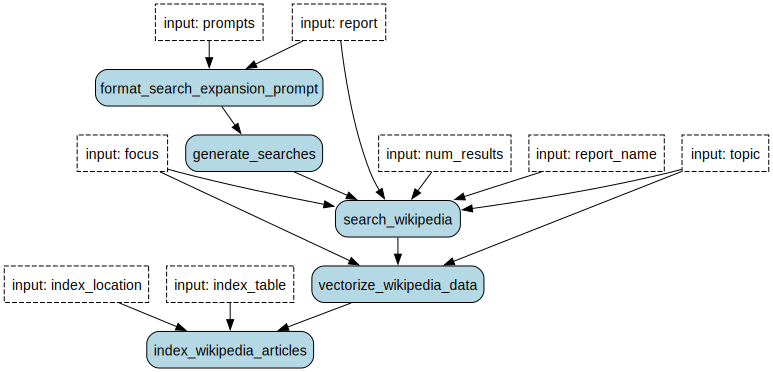

In [28]:
wiki_search_app.visualize("./graph", format="png")

In [29]:
with open(trace_data.joinpath(short_name + '.json'), 'r') as f:
    report_data = json.load(f)

In [30]:
wiki_action, wiki_result, wiki_state = wiki_search_app.run(
    halt_after=["index_wikipedia_articles"],
    inputs={
        "topic": report_data['topic'],
        "focus": report_data['focus'],
        "num_results": 10,
        "report": report_data['report'],
        "report_name": short_name,
        "prompts": {"search_expansion_prompt":wikipedia_query_prompt},
        "index_location": index_locations['index_path'],
        "index_table": 'tmp_index'

    }
)

['Digital divide', 'Rural internet', 'Global digital divide', 'Internet access', 'Digital divide in the United States', 'Internet in Canada', 'Broadband universal service', 'NTCA - The Rural Broadband Association', 'Digital divide in Malaysia', 'Internet in Africa']
['Universal Service Fund', 'Internet in the United States', 'Broadband universal service', 'Universal service', 'Universal Service Provision Fund', 'National broadband plan', 'Lifeline (FCC program)', 'NTCA - The Rural Broadband Association', 'Bharat Broadband Network', 'National Broadband Initiative (Malaysia)']
['Internet in the United States', 'Broadband mapping in the United States', 'National broadband plan', 'Rural internet', 'Beth Ford', 'National Digital Inclusion Alliance', 'National Broadband Plan (United States)', 'Internet access', 'Internet in China', 'Digital divide']


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
wiki_data = wiki_state.get_all()

In [32]:
with open(trace_data.joinpath(short_name + '_wikipedia.json'), 'w') as f:
    json.dump(wiki_data, f)

# Trend Report Burr

In [63]:
def format_sections_w_citations(wiki_document, base_citation):
    first_section = wiki_document[0]
    current_level_1_idx = 1
    current_level_2_idx = 1
    current_level_1_name = first_section['hierarchy']['level_0']
    current_level_2_name = first_section['hierarchy']['level_1']
    formatted_sections = list()
    base_citation = '_'.join(re.findall(r'(\w+)', base_citation))

    first_section['citation'] = f"{base_citation}({current_level_1_idx})({current_level_2_idx})"
    formatted_sections.append(first_section)
    if len(wiki_document) > 1:
        for section in wiki_document[1:]:
            # if current_level_1_name == '':
            #     current_level_1_name = section['hierarchy']['level_0']
            # if current_level_2_name == '':
            #     current_level_2_name = section['hierarchy']['level_1']
            #     current_level_2_idx = 1

            if current_level_1_name != section['hierarchy']['level_0']:
                current_level_1_name = section['hierarchy']['level_0']
                current_level_2_name = section['hierarchy']['level_1']
                current_level_1_idx += 1
                current_level_2_idx = 1
                # print(current_level_1_name)
            elif (current_level_1_name == section['hierarchy']['level_0']) and (current_level_2_name != section['hierarchy']['level_1']):
                current_level_2_name = section['hierarchy']['level_1']
                current_level_2_idx += 1
            else:
                current_level_2_idx += 1

            section['citation'] = f"{base_citation}({current_level_1_idx})({current_level_2_idx})"
            # print(section['citation'])
            formatted_sections.append(section)
            # current_level_1_idx += 1
            # current_level_2_idx = 1
    return formatted_sections

In [64]:
trend_analysis_prompt = """
***Report:***
{report}

***Sources for the report:***
{sources}

-----
Write a trend report on the topic: {topic}, with a primary focus on: {focus}. Identify the overall trends that concern:
- Evolving states of the status quo
- Challenges faced historically and/or currently
- Initiatives and solutions to challenges
- Outlook
- Drivers of change, challenges, and/or solutions.

Organize your trend analysis by each trend being a section with the name of the trend formatted as a markdown header '##' and sub-points as a markdown numbered, or bullet pointed, list.

Your analysis should provide the citations from the source material for the different statements providing information about the trend, or claims about the trend. The citation format can be found in the report text and in the sources in the format of '(report_name(section_number))'.

Only use information that is directly corroborated by the sources of information.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the answer.
Focus solely on fulfilling the request.

Trends:
"""

In [65]:
follow_up_context_prompt = """
## Report:
{report}

## Trend Analysis:
{trend_analysis}

-----

Identify the specific context needed to give contextual information on historical conditions, drivers of trends, status quo, outlook for the future, challenges being faced, and initiatives from the report, trend analysis, topic: {topic} and a focus on: {focus}. This context must be the specific context needed to retrieve additional contextual information on historical conditions, drivers of trends, status quo, outlook for the future, challenges being faced, and initiatives.

Respond with phrases that will identify the documents and information within the documents that adds context to the report, trend analysis, topic, and focus. Just respond with the requested list. The sections provided below MUST start with a '#' and the bullet points MUST use '-' as the markdown list bullet point. You must provide a list beneath each section.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the answer.
Focus solely on fulfilling the request.

-----

## Historical Conditions:

## Status Quo:

## Drivers of Trends:

## Challenges faced historically and/or currently:

## Initiatives and solutions to challenges:

## Outlook:

"""

In [149]:
extract_contextual_information_wikipedia = """Extract relevant information from the article that provides context and key details about the topic: Rural Broadband in America, that has  a primary focus driven by: Historical, current, and future challenges for rural broadband and connectivity in America, or is good context for what is in the Trend Analysis.

Use the areas of interest for context on what is important for you to extract. It is absolutely critical that you do not introduce yourself, your response, or provide a conclusion or outro. Just respond with the extracted information.

Under no circumstances are you to reference or repeat information in the Trend Analysis.

-----

# Areas of Interest:
{areas_of_interest}

# Trend Analysis:
{trend_analysis}

-----

# Article:
{article}

-----

The sections of the article may not have relevant information to anything in the trend analysis or anything in the area of interest. If no relevant information is in the article, only respond with "No relevant information".

Only use what is available to extract the necessary context. Extract the key details that provide relevant context and information in the scope of the areas of interest or are relevant context to the trend analysis. At the end of each section, you will find the citation for that section in the form of (document_id(section_number)(subsection_number)). For each piece of information you extract, provide the source citation for it. This is an absolute must.

When extracting multiple pieces of information from the same section, condense them into a single bullet point unless they relate to distinct areas in areas of interest.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the response.
Focus solely on fulfilling the request.

ONLY use the information from the Article for your response. Do NOT respond with any information from the Trend Analysis. Under no circumstance provide information from the Trend Analysis. Only information from the Article is intended to be extracted.

When responding, align the information extracted with these fields that structure the areas of interest:

## Historical Conditions:

## Status Quo:

## Drivers of Trends:

## Challenges faced historically and/or currently:

## Initiatives and solutions to challenges:

## Outlook:

-----

# Extracted Information:
"""

In [166]:
extract_contextual_information_wikipedia = """Extract relevant information from the article that provides context and key details about the topic: Rural Broadband in America, that has  a primary focus driven by: Historical, current, and future challenges for rural broadband and connectivity in America, and areas of interest that provide useful context.

Use the areas of interest for context on what is important for you to extract. It is absolutely critical that you do not introduce yourself, your response, or provide a conclusion or outro. Just respond with the extracted information.

-----

# Areas of Interest:
{areas_of_interest}

-----

# Article:
{article}

-----

The sections of the article may not have relevant information to anything in the area of interest. If no relevant information is in the article, only respond with "No relevant information".

Only use what is available to extract the necessary context. Extract the key details that provide relevant context and information in the scope of the areas of interest or are relevant context to the trend analysis. At the end of each section, you will find the citation for that section in the form of (document_id(section_number)(subsection_number)). For each piece of information you extract, provide the source citation for it. This is an absolute must.

When extracting multiple pieces of information from the same section, condense them into a single bullet point unless they relate to distinct areas in areas of interest.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the response.
Focus solely on fulfilling the request.

ONLY use the information from the Article for your response. Only information from the Article is intended to be extracted.

For all information you extract, organize it under the appropriate header provided below. If no information is available for that header, then do not provide that header.

## Historical Conditions:

## Status Quo:

## Drivers of Trends:

## Challenges faced historically and/or currently:

## Initiatives and solutions to challenges:

## Outlook:
"""

In [167]:
trend_interpolation_prompt = """Write a trend report based on a trend analysis that captures the general trends about the topic: {topic} with the focus being: {focus}. Use the set of notes on relevant information to the trend report.

The current trend analysis provides only partial information about the topic and the focus. Using just the relevant information from the notes, write an additional trend report based on the notes provided. Do not use the material in the existing trend report for writing this new analysis, unless the new information from the notes directly relates to a claim or statement in it. When using information from the existing trend analysis you must provide the citation of the claim or statement from the existing trend analysis.

Do not provide opinions, interpretation, introduction, conclusion, or any sort of introduction to your response. Only write a new report.

Structure the new report to use the same sections and section headers as the provided trend analysis. If there is no information to add to an existing section of the trend analysis, write that no new information was found.

The information used to write the new the trend report *must* only come from the notes. Do not add any information that has not been provided in the notes or the trend analysis. Add as much contextual information as is available to your report with a focus on completeness of information over brevity. It's vital that the report is grounded on facts in the notes.

Next, add a section at the end with any case studies that are in the notes. Separate these by a title for each case study and provide the current conditions, situation of the case study, and how it relates to a specific trend in the trend report. Clearly label this in a separate section for each trend with the header "## Case Studies:" Only include case studies that have information on what was the problem, solution, and outcome for the case study.

Do not include any introductory phrases (e.g., 'Okay,' 'Sure,' 'Here's').
Do not include any concluding remarks or follow-up questions.
Respond only with the requested information.
Avoid any conversational filler.
Do not engage in dialogue. Only provide the answer.
Focus solely on fulfilling the request.


# Trend Analysis:
{trend_analysis}

# Notes:
{notes}

# Trend Report:
"""

In [181]:
@action(reads=[], writes=["formatted_trend_report_prompt"])
def format_trend_report_prompt(state: State, report: str, sources: str, prompts: dict, topic: str, focus: str) -> State:
    formatted_prompt = prompts['trend_report_prompt'].format(topic=topic, focus=focus, report=report, sources=sources)
    return state.update(formatted_trend_report_prompt=formatted_prompt)

@action(reads=["formatted_trend_report_prompt"], writes=["trend_report"])
def generate_trend_report(state: State) -> State:
    # trend_report = call_llm(state['formatted_trend_report_prompt'], model="gemma-3-12b-it-qat")
    trend_report = call_llm_flash(state['formatted_trend_report_prompt'])
    return state.update(trend_report=trend_report)

@action(reads=["trend_report"], writes=["follow_ups"])
def create_follow_up_context(state: State, prompts: dict, topic: str, focus: str, report: str) -> State:
    follow_up_prompt = prompts['follow_up_context_prompt'].format(topic=topic, focus=focus,
                                                                  report=report, trend_analysis=state['trend_report'])
    # follow_ups = call_llm(follow_up_prompt, model="gemma-3-12b-it-qat")
    follow_ups = call_llm_flash(follow_up_prompt)
    return state.update(follow_ups=follow_ups)

@action(reads=["follow_ups"], writes=["follow_up_groups"])
def create_follow_up_queries(state: State) -> State:
    different_followups = re.findall(r'#+\s+(.*?)(?:$|#)', state['follow_ups'], flags=re.DOTALL)
    follow_up_groups = dict()
    for group in different_followups:
        group_name = group.split('\n')[0]
        followups = re.findall(r'[\*-]\s*(.+?)(?:\n|$)', group, flags=re.DOTALL)
        followups = [x.strip() for x in followups]
        follow_up_groups[group_name.strip()] = followups
    return state.update(follow_up_groups=follow_up_groups)

@action(reads=["follow_up_groups"], writes=['follow_up_results'])
def search_follow_ups(state: State, index_locations: dict, num_results: int, search_depth: int) -> State:
    index = lancedb.connect(index_locations['index_path'])
    table = index.open_table(index_locations['index_table'])

    follow_up_documents = list()
    for follow_up_area, followup_group in state['follow_up_groups'].items():
        area_documents = list()
        for follow_up in followup_group:
            follow_up_vector = encoder.encode(follow_up).tolist()
            torch.mps.empty_cache()

            follow_up_search_vector = table.search(follow_up_vector).distance_type('cosine').limit(search_depth).to_list()
            _fts_query = re.findall(r'(\w+)', follow_up)
            _fts_query = ' '.join(_fts_query)
            follow_up_search_fts = table.search(_fts_query).limit(search_depth).to_list()

            for _result in follow_up_search_vector:
                _result['follow_up_area'] = follow_up_area
                _result['follow_up_focus'] = follow_up

            for _result in follow_up_search_fts:
                _result['follow_up_area'] = follow_up_area
                _result['follow_up_focus'] = follow_up

            area_documents.extend(follow_up_search_vector)
            area_documents.extend(follow_up_search_fts)
        area_documents = pd.DataFrame(area_documents)
        area_documents['_score'] = area_documents.groupby(['page_title','section_idx'])['_score'].transform('max')
        area_documents['_distance'] = area_documents.groupby(['page_title','section_idx'])['_distance'].transform('max')

        area_documents['norm_score'] = (area_documents['_score'] - area_documents['_score'].min()) / (area_documents['_score'].max() - area_documents['_score'].min())
        area_documents['norm_distance'] = (area_documents['_distance'] - area_documents['_distance'].min()) / (area_documents['_distance'].max() - area_documents['_distance'].min())

        area_documents['fusion_score'] = 0.5*area_documents['norm_distance'] + 0.5*area_documents['norm_score']
        area_documents = area_documents.sort_values(by=['fusion_score'], ascending=False)
        area_documents = area_documents.drop_duplicates(subset=['page_title','section_idx'], keep='first')
        area_documents = area_documents.dropna(subset=['fusion_score'])
        area_documents = area_documents.iloc[:num_results]

        follow_up_documents.append(area_documents)


    follow_up_results = pd.concat(follow_up_documents)
    follow_up_results['norm_global_score'] = (follow_up_results['_distance'] - follow_up_results['_distance'].min()) / (follow_up_results['_distance'].max() - follow_up_results['_distance'].min())

    follow_up_results = follow_up_results.sort_values(by=['norm_global_score'], ascending=False)
    follow_up_results = follow_up_results.drop_duplicates(subset=['page_title','section_idx'], keep='first')
    follow_up_results['section_start'] = follow_up_results.groupby(['page_title','hierarchy_string'])['section_idx'].transform('min')
    follow_up_results = follow_up_results.sort_values(by=['page_title','section_start','section_idx'])
    follow_up_results = follow_up_results.drop_duplicates(subset=['text'])
    follow_up_results = follow_up_results[follow_up_results['text'].str.strip() != '']
    follow_up_results = follow_up_results.drop('vector', axis=1)
    print(follow_up_results.head())
    print(follow_up_results['page_title'].nunique())
    print(follow_up_results.shape)

    return state.update(follow_up_results=follow_up_results.to_dict(orient='records'))

# @action(reads=[], writes=[])
# def clean_up_results(state: State) -> State:
#     return state

@action(reads=["follow_up_results"], writes=["formatted_documents"])
def format_results(state: State) -> State:
    formatted_documents = list()
    context_documents_df = pd.DataFrame(state['follow_up_results'])
    print(context_documents_df.head())
    for _page_title, _group in context_documents_df.groupby(['page_title']):
        # group_text = '\n\n'.join(_group['text'])
        formatted_wiki_text = format_sections_w_citations(_group.to_dict(orient='records'), _page_title[0])
        group_text = ""
        for section in formatted_wiki_text:
            _formatted_section = f"\n- {section['text']} ({section['citation']})"
            group_text += _formatted_section
        group_text = group_text.strip()
        formatted_documents.append({'title':_page_title[0], "document":f"#### Title: {_page_title[0]}\n\n{group_text}"})
    return state.update(formatted_documents=formatted_documents)


@action(reads=['formatted_documents','follow_ups'], writes=['extracted_page_data','formatted_extraction_prompt'])
def extract_page_data(state: State, topic: str, focus: str, prompts: dict) -> State:
    extracted_page_data = list()
    print(len(state['formatted_documents']))
    for i, page in enumerate(state['formatted_documents']):
        print(f"Extracting page {i}")
        formatted_extraction_prompt = prompts['extract_contextual_information_wikipedia'].format(topic=topic, focus=focus,
                                                                                                 areas_of_interest=state['follow_ups'],
                                                                                                 trend_analysis=state['trend_report'],
                                                                                                 article=page['document'])
        extracted_information = call_llm(formatted_extraction_prompt, model="gemma-3-4b-it-qat", temperature=0.3)
        extracted_page_data.append({'title':page['title'], 'extracted_information': extracted_information})

    return state.update(extracted_page_data=extracted_page_data, formatted_extraction_prompt=formatted_extraction_prompt)

@action(reads=['extracted_page_data','trend_report'], writes=['trend_report_wiki_context','formatted_trend_prompt'])
def generate_trend_report_context(state: State, topic: str, focus: str, prompts: dict) -> State:
    extracted_page_notes = list()
    for page in state['extracted_page_data']:
        if 'no relevant information' in page['extracted_information'].lower():
            continue
        extracted_page_notes.append(f"Article Title: {page['title']}\nArticle Text: {page['extracted_information']}".strip())

    formatted_trend_prompt = prompts['trend_interpolation_prompt'].format(topic=topic, focus=focus,
                                                                             trend_analysis=state['trend_report'],
                                                                             notes='\n\n'.join(extracted_page_notes))
    # trend_report_wiki_context = call_llm(formatted_trend_prompt, model="gemma-3-12b-it-qat")
    trend_report_wiki_context = call_llm_flash(formatted_trend_prompt)
    return state.update(trend_report_wiki_context=trend_report_wiki_context, formatted_trend_prompt=formatted_trend_prompt)

In [182]:

trend_report_app = (
    ApplicationBuilder()
    .with_actions(
        format_trend_report_prompt,
        generate_trend_report,
        create_follow_up_context,
        create_follow_up_queries,
        search_follow_ups,
        format_results,
        extract_page_data,
        generate_trend_report_context
    )
    .with_transitions(
        ("format_trend_report_prompt", "generate_trend_report"),
        ("generate_trend_report", "create_follow_up_context"),
        ("create_follow_up_context", "create_follow_up_queries"),
        ("create_follow_up_queries", "search_follow_ups"),
        ("search_follow_ups", "format_results"),
        ("format_results", "extract_page_data"),
        ("extract_page_data", "generate_trend_report_context"),
    )
    .with_entrypoint("format_trend_report_prompt")
    .with_tracker(
        "local",
        project=f"research_batch-trend_analysis",
    )
    .build()
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


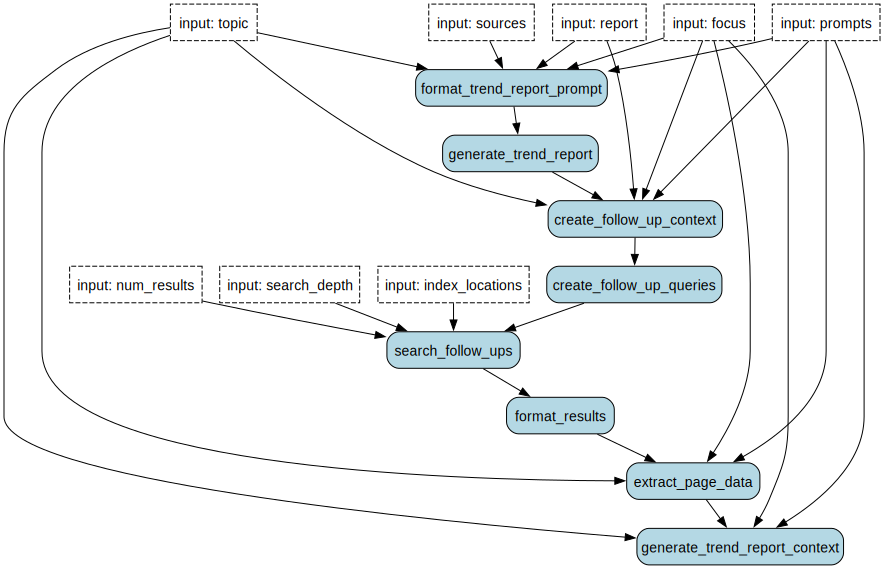

In [183]:
trend_report_app.visualize("./graph", format="png")

In [184]:
report_data.keys()

dict_keys(['__SEQUENCE_ID', 'search_expansion_prompt', '__PRIOR_STEP', 'search_expansion', 'query_expansion', 'documents', 'extraction_prompt', 'extraction', 'report_grounding', 'relevant_citations', 'formatted_report_grounding', 'report_prompt', 'report', 'topic', 'focus'])

In [185]:
trend_action, trend_result, trend_state = trend_report_app.run(
    halt_after=["generate_trend_report_context"],
    inputs={
        "topic": report_data['topic'],
        "focus": report_data['focus'],
        "search_depth":40,
        "num_results": 10,
        "report": report_data['report'],
        "sources": report_data['formatted_report_grounding'],
        "prompts": {"trend_report_prompt":trend_analysis_prompt,
                    "follow_up_context_prompt":follow_up_context_prompt,
                    "extract_contextual_information_wikipedia":extract_contextual_information_wikipedia,
                    "trend_interpolation_prompt":trend_interpolation_prompt},
        "index_locations": {'index_path': index_locations['index_path'],
                           'index_table':'wiki_research'},


    }
)

     level                     title  \
247      0  Politics and controversy   
56       1             United States   
189      2            Funding system   
94       1            Infrastructure   
39       1                  Location   

                                                  text  \
247  Politics influences the allocation of funds. T...   
56   Based on a survey conducted by the United Stat...   
189  One of the biggest concerns regarding universa...   
94   The infrastructure by which individuals, house...   
39   One can connect to the internet in a variety o...   

                                             hierarchy  \
247  {'level_0': 'Politics and controversy', 'level...   
56   {'level_0': 'Implementation', 'level_1': 'Unit...   
189  {'level_0': 'Implementation', 'level_1': 'Unit...   
94   {'level_0': 'Aspects', 'level_1': 'Infrastruct...   
39   {'level_0': 'Aspects', 'level_1': 'Location', ...   

                                hierarchy_string             

In [186]:
trend_trace = trend_state.get_all()

In [187]:
trend_trace.keys()

dict_keys(['__SEQUENCE_ID', 'formatted_trend_report_prompt', '__PRIOR_STEP', 'trend_report', 'follow_ups', 'follow_up_groups', 'follow_up_results', 'formatted_documents', 'extracted_page_data', 'formatted_extraction_prompt', 'trend_report_wiki_context', 'formatted_trend_prompt'])

In [188]:
print(trend_trace['trend_report'])

## The Persistent Digital Divide

1.  Rural areas lag behind urban and suburban areas in broadband deployment (RL33816(6)).
2.  As of year-end 2017, 24% of Americans in rural areas and 32% of Americans in Tribal lands lacked coverage from fixed terrestrial 25 Mbps/3 Mbps broadband, compared to only 1.5% of Americans in urban areas (RL33816(6)).
3.  Rural areas continue to lag behind urban areas in mobile broadband deployment (RL33816(6)).
4.  In 2017, 58% of adults in rural areas said they have a high-speed broadband connection at home, as opposed to 67% of adults in urban areas and 70% of adults in suburban areas (RL33816(6)).
5.  A 2017 Census Bureau survey reported 72.9% of rural residents reporting using the internet, versus 78.5% of urban residents (RL33816(6)).
6.  Rural residents tend to have lower adoption rates for broadband than urban residents (R47017(2)).
7.  The "digital divide" refers to the gap between Americans who have access to telecommunications and information techn

In [189]:
print(trend_trace['trend_report_wiki_context'])

## The Persistent Digital Divide

In 2011, approximately one-third of American households lacked a broadband connection (NTIA, 2011). Broadband adoption rates differed significantly by race; White (68%) and Asian non-Hispanics (69%) had higher rates than Black non-Hispanics (50%) and Hispanics (45%) (NTIA, 2011). Rural America lagged behind urban areas in broadband access, with a 60% adoption rate compared to 70% in urban areas (NTIA, 2011). As of June 2020, approximately 4 out of 5 Americans have internet access, but disparities exist based on demographics like geography and socioeconomic status (Digital_divide_in_the_United_States(1)(1)). Approximately 23 million Americans do not have access to a broadband connection at home, representing 23% of the population (Digital_divide_in_the_United_States(1)(1)). In 2021, 77% of Americans had home broadband according to Pew Research Center (Rural_internet(1)(1)). In 2017, only 73.6% of the rural population had access to broadband services at 

In [190]:
with open(trace_data.joinpath(short_name + '_trends.json'), 'w') as f:
    json.dump(trend_trace, f)
with open(document_data.joinpath(short_name + '_trend_report.md'), 'w') as f:
    f.write(trend_trace['trend_report'])
with open(document_data.joinpath(short_name + '_trend_report_wiki.md'), 'w') as f:
    f.write(trend_trace['trend_report_wiki_context'])

In [191]:
trace_data

PosixPath('wonky_data/data/research_data')

In [192]:
document_data

PosixPath('wonky_data/documents')

In [193]:
print(trend_trace['formatted_extraction_prompt'])

Extract relevant information from the article that provides context and key details about the topic: Rural Broadband in America, that has  a primary focus driven by: Historical, current, and future challenges for rural broadband and connectivity in America, and areas of interest that provide useful context.

Use the areas of interest for context on what is important for you to extract. It is absolutely critical that you do not introduce yourself, your response, or provide a conclusion or outro. Just respond with the extracted information.

-----

# Areas of Interest:
## Historical Conditions:

-   Early telecommunications infrastructure development in rural areas.
-   Initial federal and state efforts to promote rural telephony.
-   Evolution of broadband technologies and their availability in urban vs. rural areas.
-   Historical funding mechanisms for rural telecommunications.

## Status Quo:

-   Current broadband deployment rates in rural vs. urban areas.
-   Adoption rates of broa